Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

import xarray as xr
import matplotlib.ticker as mticker
from matplotlib import colors as c
import geopandas
from shapely.geometry import Point, Polygon
import regionmask
import descartes

Run regionmask.ipynb to import catchment shapefiles

['Hydrologi_TotalNedborfeltMalestasjon.shx']
objType                                   NedbørfeltMålestasjon
feltNr                                                     1902
stSamletID                                         016000001000
stID                                                    160.1.0
stNavn                                             Storglåmvatn
areal_km2                                                251.85
Q6190Mm3Aa                                               797.15
Q6190mmAar                                              3165.18
Q6190lskm2                                               100.32
vf6190m3s                                                 25.27
uttakDato                                            2021-09-23
ekspType                               NVEs nedlastningsløsning
geometry      POLYGON Z ((14.35082813994262 66.7934058783317...
Name: 0, dtype: object
objType                                   NedbørfeltMålestasjon
feltNr                              

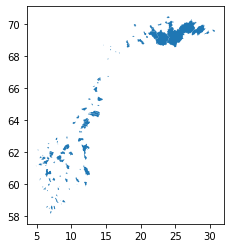

In [4]:
%run regionmask.ipynb

Test if worked

In [5]:
st_regions

<regionmask.Regions>
Name:     catchment

Regions:
  0   r0  209.4.0
  1   r1  172.7.0
  2   r2  178.1.0
  3   r3  185.1.0
  4   r4  246.9.0
..   ...      ...
119 r119 123.31.0
120 r120   98.4.0
121 r121  25.24.0
122 r122   79.3.0
123 r123   88.4.0

[124 regions]

Collect data from where it is saved

In [7]:
year = 1990
inner_path = 'senorge_rr_tg/senorge_rr_tg'


mfdataDIR_qtt = "/Volumes/Sunniva's h/senorge_rr_tg/seNorge2018_" + str(year) + ".nc"
variable_senorge = 'tg'
QTT = xr.open_mfdataset(mfdataDIR_qtt)[variable_senorge]
QTT

<xarray.DataArray 'tg' (time: 365, Y: 1550, X: 1195)>
dask.array<open_dataset-d5c960c603bf8ced457831c4a26ad6c7tg, shape=(365, 1550, 1195), dtype=float32, chunksize=(365, 1550, 1195), chunktype=numpy.ndarray>
Coordinates:
  * X        (X) float64 -7.45e+04 -7.35e+04 -7.25e+04 ... 1.118e+06 1.12e+06
  * Y        (Y) float64 8e+06 7.998e+06 7.998e+06 ... 6.452e+06 6.45e+06
  * time     (time) datetime64[ns] 1990-01-01T06:00:00 ... 1990-12-31T06:00:00
    lon      (Y, X) float32 dask.array<chunksize=(1550, 1195), meta=np.ndarray>
    lat      (Y, X) float32 dask.array<chunksize=(1550, 1195), meta=np.ndarray>
Attributes:
    units:          Celsius
    grid_mapping:   UTM_Zone_33
    standard_name:  air_temperature
    cell_methods:   time: mean
    prod_date:      2021-08-07
    long_name:      daily mean temperature (06UTC-06UTC)
    DOI:            10.5281/zenodo.5205509
    version:        21.09

Make definition to collect data from where it is stored, and mask through the catchments defined in regionmask.ipynb. Then save new file with data containing catchments and belonging data

In [8]:
def run_senorge(year, st_regions, st_names, variable_senorge, inner_path):
    mfdataDIR_qtt = "/Volumes/Sunniva's h/"+inner_path+"_" + str(year) + ".nc"
    DS = xr.open_mfdataset(mfdataDIR_qtt)[variable_senorge]
    mask_regions = st_regions.mask(DS.lon, DS.lat)
    
    multiple_stIDs = []
    for i in range(0,len(st_regions)):
        multiple_stIDs.append(st_names[i])

    multi_d = []
    for i in range(0,len(st_regions)):
        multi_key = st_regions.map_keys(multiple_stIDs[i])
        multi_d.append(DS.where(mask_regions == multi_key))
    DS.close()

    #multi_mean = multi_d[0].mean(dim=['x','y']).to_dataframe()
    multi_mean = multi_d[0].mean(dim=['X','Y']).to_dataframe()
    multi_mean = multi_mean.rename(columns={multi_d[0].name: multiple_stIDs[0]})

    for i in range(1,len(multi_d)):
        multi_mean[multiple_stIDs[i]]= multi_d[i].mean(dim=['X','Y']).to_dataframe()
        #multi_mean[multiple_stIDs[i]]= multi_d[i].mean(dim=['x','y']).to_dataframe()

    multi_mean.to_csv(variable_senorge+'/'+variable_senorge + '_' + str(year) + '.csv')
    print('Saved file: '+ variable_senorge+'/'+variable_senorge + '_' + str(year) + '.csv')
    

Choose which file is run through definition and for what time period.

In [ ]:
variable_senorge = 'tg'
inner_path='senorge_rr_tg/seNorge2018'


for year in range(1991, 2021):
    run_senorge(year, st_regions, st_names, variable_senorge, inner_path)